# Working with Reve in Pixeltable

Pixeltable's Reve integration lets you call Reve's `create`, `edit`, and `remix` endpoints directly from tables so you can iterate on visuals without leaving your data workflows.

### Documentation

- [Pixeltable Reve Functions](https://docs.pixeltable.com/sdk/latest/reve#module-pixeltable-functions-reve)
- [Reve API Reference](https://api.reve.com/console/docs)

### Prerequisites
- A Reve account with an API key (<https://app.reve.com/> → Settings → API Keys)

### Important Notes
- Reve usage incurs costs according to your plan—keep an eye on credits.
- Images you send to Reve leave your environment; avoid uploading sensitive or private data.

First you'll install the required libraries and provide the `REVE_API_KEY`. Then we'll walk through each Reve endpoint—`create`, `edit`, and `remix`—one at a time, using separate Pixeltable tables for each workflow.


In [ ]:
%pip install -qU pixeltable

In [ ]:
import os
import getpass

if 'REVE_API_KEY' not in os.environ:
    os.environ['REVE_API_KEY'] = getpass.getpass('Reve API Key: ')

## Setup

We start by creating a Pixeltable directory to keep the tables for this demo separate from anything else you're working on. The table we'll build up to will require two inputs per row:

1. A prompt for creating a scene image. We'll use this prompt for Reve to create a scene that we'll use as the background image for step 3.
2. A URL to an image. We'll ask Reve to edit this image, and then it will be ready as the foreground image for step 3.
3. Finally, we'll remix the background scene image we made in step 1 and add the 

In [1]:
import pixeltable as pxt

In [2]:
pxt.create_dir('reve_demo', if_exists='replace_force')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'reve_demo'.


We'll create a Pixeltable table that starts with a prompt and ends with a final scene. To begin with, we'll create an empty table with a column for a single prompt:

In [3]:
spunk_t = pxt.create_table('reve_demo.solarpunk_scenes', {'prompt': pxt.String})

Created table 'solarpunk_scenes'.


You can look at the schema for this table:

In [4]:
spunk_t.describe()

<style type="text/css">
#T_5fd50_row0_col0 {
  white-space: pre-wrap;
  text-align: left;
  font-weight: bold;
}
</style>
<table id="T_5fd50">
  <thead>
  </thead>
  <tbody>
    <tr>
      <td id="T_5fd50_row0_col0" class="data row0 col0" >table 'reve_demo.solarpunk_scenes'</td>
    </tr>
  </tbody>
</table>

<style type="text/css">
#T_44b07 th {
  text-align: left;
}
#T_44b07_row0_col0, #T_44b07_row0_col1, #T_44b07_row0_col2 {
  white-space: pre-wrap;
  text-align: left;
}
</style>
<table id="T_44b07">
  <thead>
    <tr>
      <th id="T_44b07_level0_col0" class="col_heading level0 col0" >Column Name</th>
      <th id="T_44b07_level0_col1" class="col_heading level0 col1" >Type</th>
      <th id="T_44b07_level0_col2" class="col_heading level0 col2" >Computed With</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_44b07_row0_col0" class="data row0 col0" >prompt</td>
      <td id="T_44b07_row0_col1" class="data row0 col1" >String</td>
      <td id="T_44b07_row0_col2" class="data row0 col2" ></td>
    </tr>
  </tbody>
</table>


## Generate new imagery with `reve.create`

Use `reve.create()` when you want Reve to synthesize an entirely new image from a prompt. In Pixeltable, start by adding a single row that only contains a text prompt. We'll generate fresh imagery from this prompt before introducing any reference photos. Feel free to change the prompt. Here we ask for a solarpunk oasis city.

In [5]:
scene_prompt = ('Create a scene of lush solarpunk metropolis in the desert '
               'with urban agriculture and an oasis theme.'
               'It should not look like an office park, corporate campus, or an outdoor mall.')
spunk_t.insert([{'prompt': scene_prompt}])

Inserting rows into `solarpunk_scenes`: 1 rows [00:00, 97.41 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 1 value computed.

We've still just added a single string as a text prompt.

In [6]:
spunk_t.collect()

prompt
"Create a scene of lush solarpunk metropolis in the desert with urban agriculture and an oasis theme.It should not look like an office park, corporate campus, or an outdoor mall."


Next, we'll actually call the `reve.create()` function inside a computed column, giving it our prompt as input. This API call locks to the `latest` model from Reve; `version` is an optional parameter.

In [7]:
from pixeltable.functions import reve

spunk_t.add_computed_column(
    new_image=reve.create(
        spunk_t.prompt,
        version='latest',
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

prompt,new_image
"Create a scene of lush solarpunk metropolis in the desert with urban agriculture and an oasis theme.It should not look like an office park, corporate campus, or an outdoor mall.",

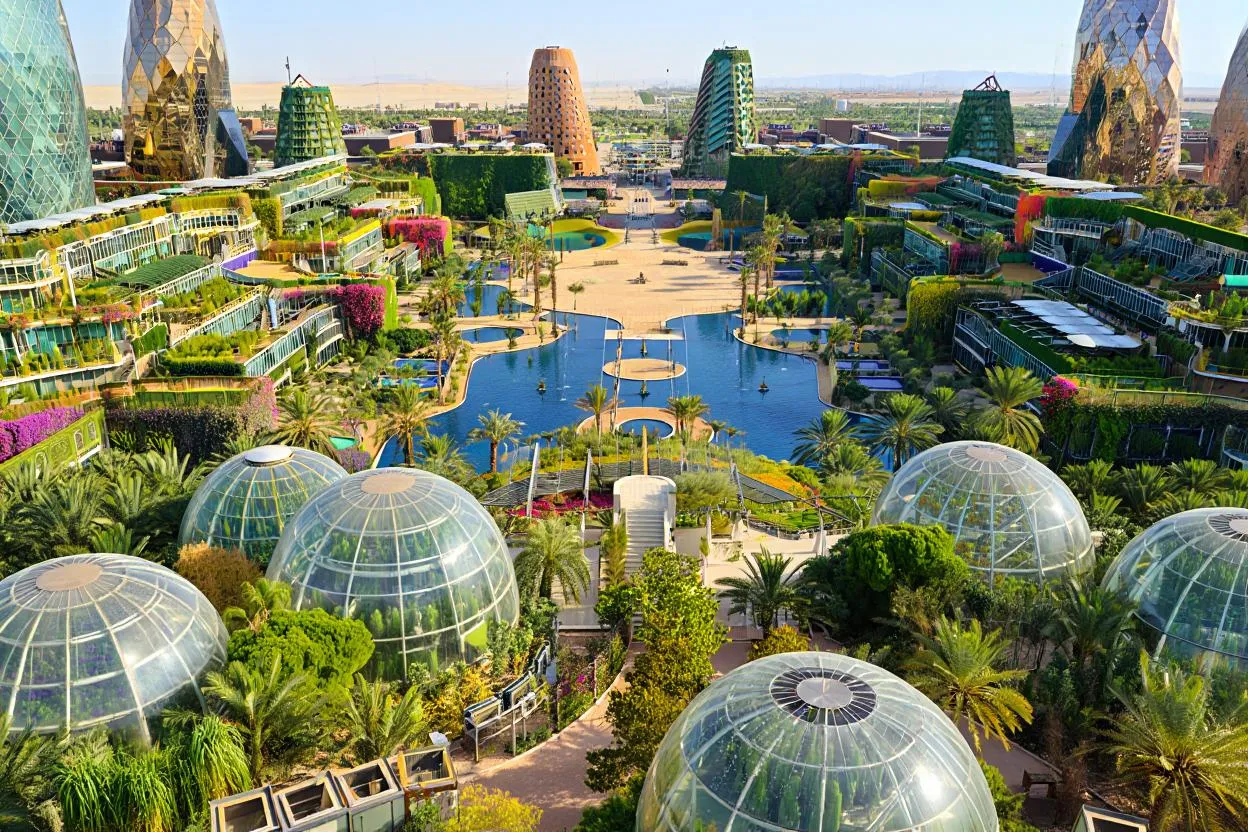

In [8]:
spunk_t.collect()

By default, Pixeltable saves all generated media outputs to a media directory. We can see the file path by using the `fileurl` property.

In [9]:
spunk_t.select(spunk_t.new_image.fileurl).collect()

new_image_fileurl
file:///Users/alison-pxt/.pixeltable/media/0df7be0e6ddc4186a88e11a591abea3f/d1/d185/0df7be0e6ddc4186a88e11a591abea3f_3_2_d18594b22e024b709635230d366ca328.jpeg


### Control aspect ratio or model version

You can pass optional parameters to `reve.create()` to shape the output. This adds a second image column using the same prompt that renders in a square frame, but we won't use the latest model.


In [10]:
spunk_t.add_computed_column(
    new_image_sq=reve.create(
        spunk_t.prompt,
        aspect_ratio='1:1'
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

prompt,new_image,new_image_sq
"Create a scene of lush solarpunk metropolis in the desert with urban agriculture and an oasis theme.It should not look like an office park, corporate campus, or an outdoor mall.",,

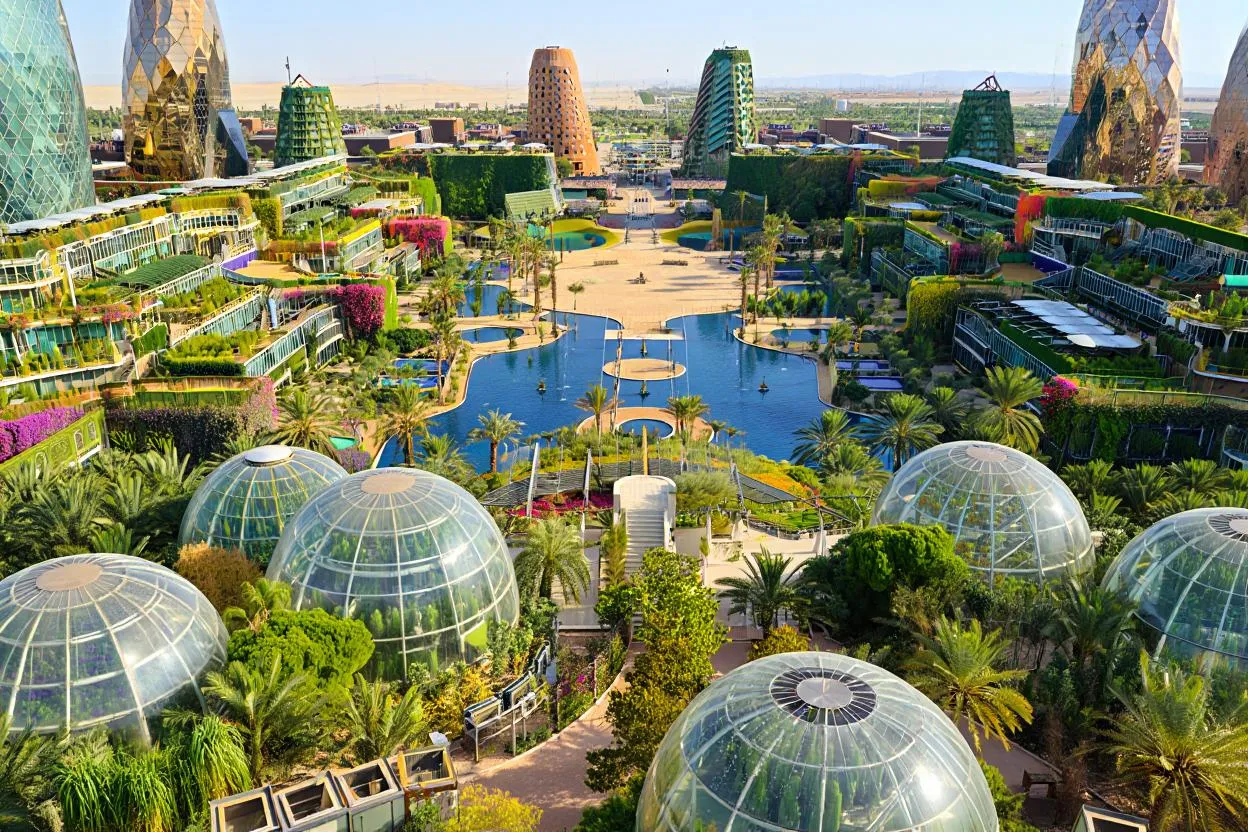
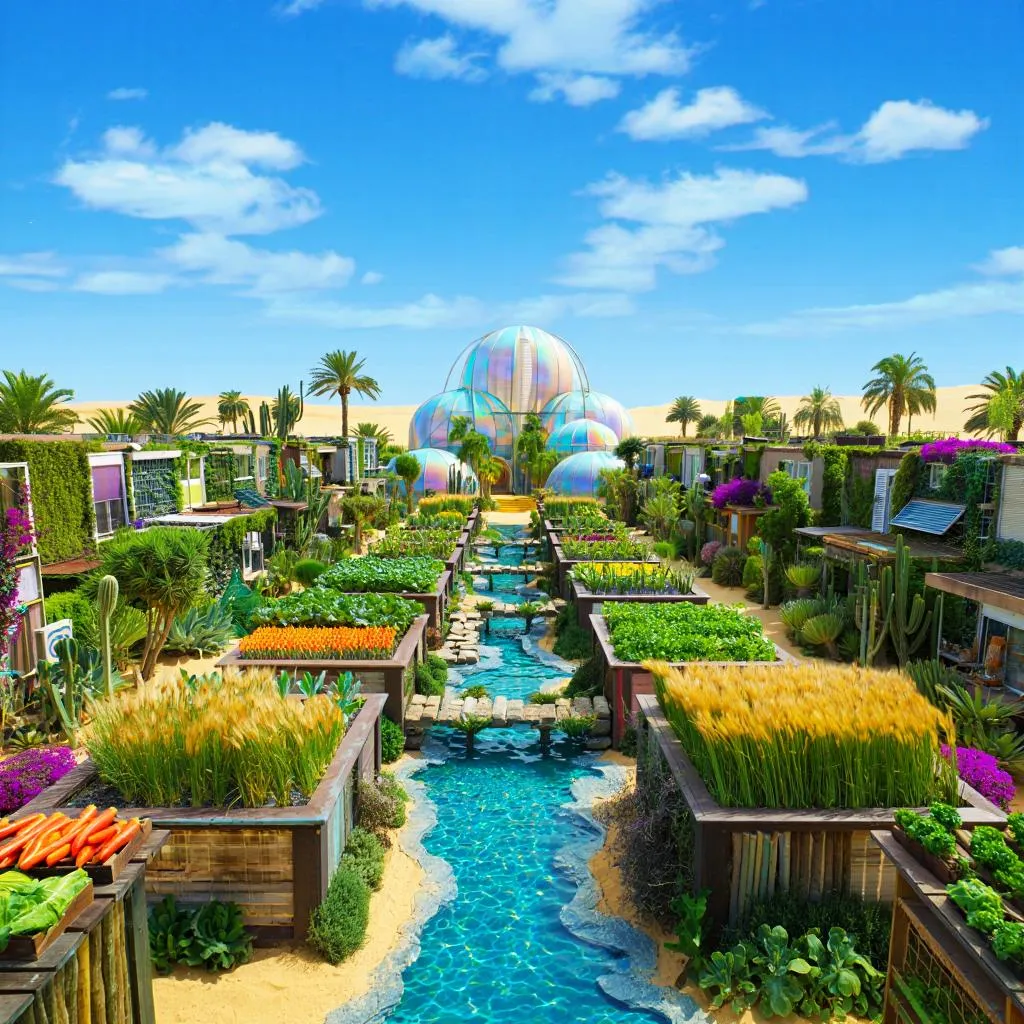

In [11]:
spunk_t.collect()

In [12]:
spunk_t.select(spunk_t.new_image_sq.fileurl).collect()

new_image_sq_fileurl
file:///Users/alison-pxt/.pixeltable/media/0df7be0e6ddc4186a88e11a591abea3f/27/2700/0df7be0e6ddc4186a88e11a591abea3f_4_3_2700a824e0b645d68789ca5221a8c571.jpeg


## Edit an existing photo with `reve.edit`

`reve.edit()` takes an existing image plus natural-language instructions and returns an edited version. Since we started with a table with only one column to store prompts, we need to now add a column for images:

In [13]:
spunk_t.add_column(source_image=pxt.Image)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [14]:
image_url = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'
spunk_t.update({'source_image': image_url})

Inserting rows into `solarpunk_scenes`: 1 rows [00:00, 879.31 rows/s]


1 row updated, 1 value computed.

Here is the image we just added:

source_image
""

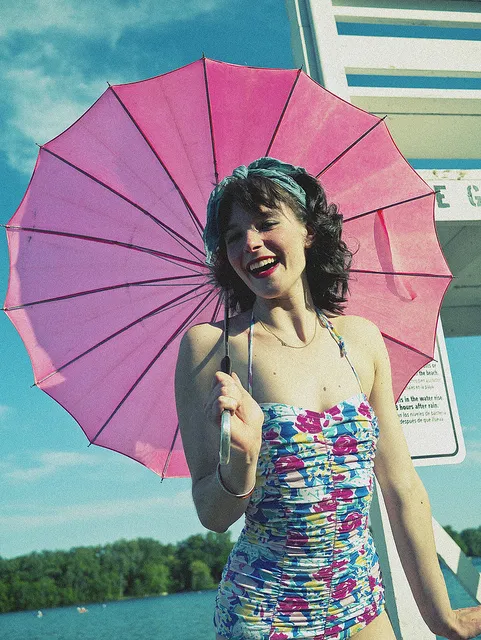

In [15]:
spunk_t.select(spunk_t.source_image).collect()

Now we'll add a computed column that calls `reve.edit()` to modify the source image. Because we are baking in this prompt into the computed column logic, we want to compose our prompt to work for future input images, so we do want it to be specific to our solarpunk theme, but do not want it to be specific to our swimmer photo. This way, when we insert a new row, the prompt will still make sense with a new input source image.

In [ ]:
# Uncomment the below line to use a Reve function, if you have not already done so
# from pixeltable.functions import reve

spunk_t.add_computed_column(
    edited_subject=reve.edit(
        spunk_t.source_image,
        'Remove any existing background. Focus on the closest person in the foreground. '
        'Keep the person and props, but make the lighting and colors vibrant and fit with a solarpunk theme. '
    )
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

We can use `collect()` to see the new image:

source_image,edited_subject
,

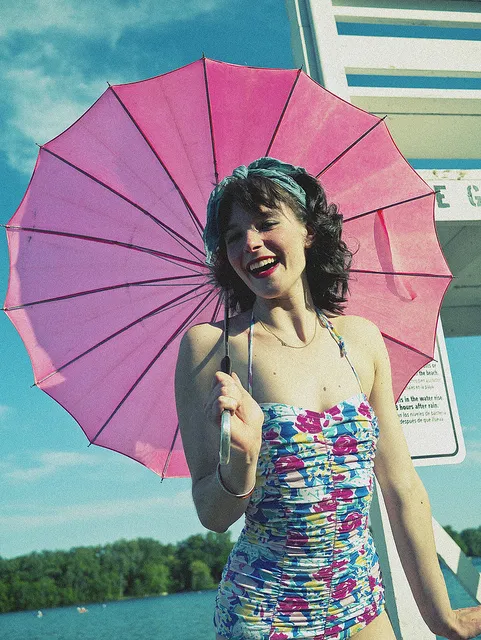
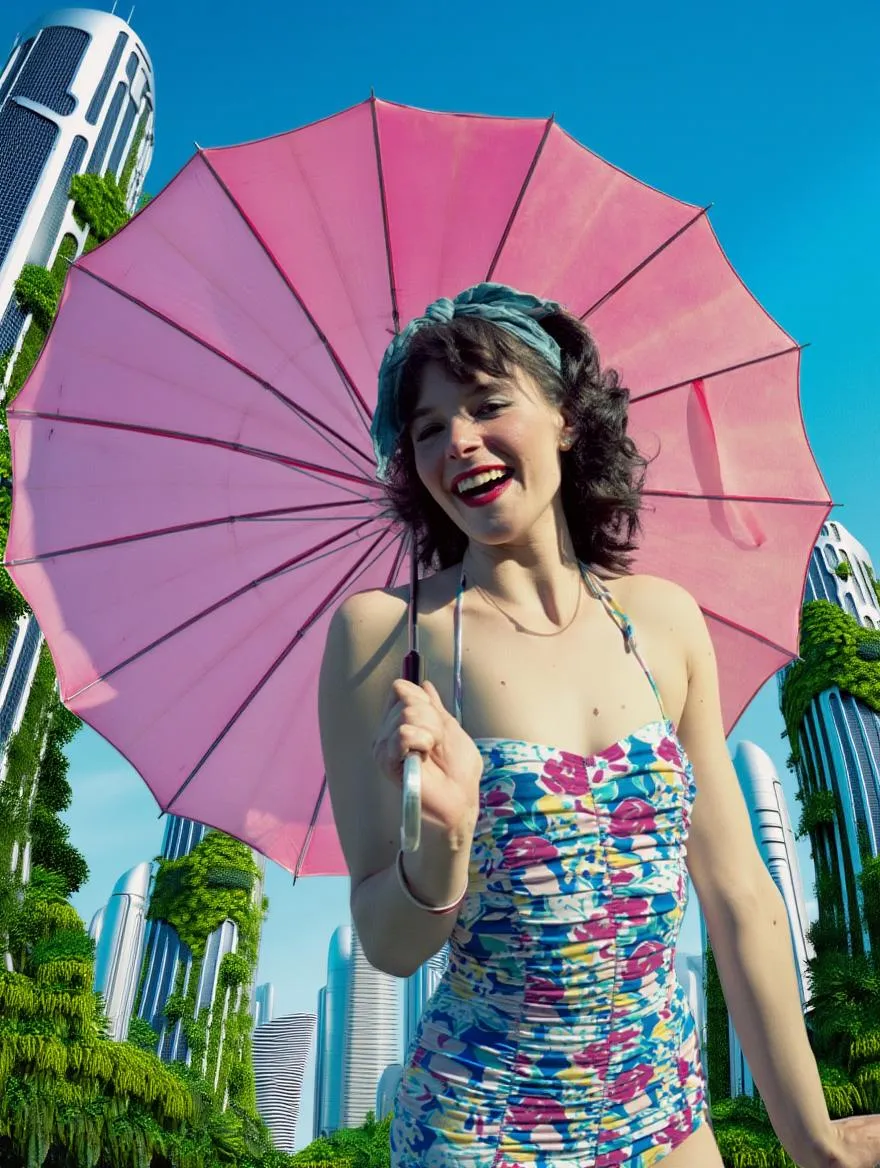

In [17]:
spunk_t.select(spunk_t.source_image, spunk_t.edited_subject).collect()

## Remix multiple references with `reve.remix`

`reve.remix()` blends multiple reference images. Inside the prompt string, you reference each image with a numbered placeholder:
- `<img>0</img>` refers to `images[0]`
- `<img>1</img>` refers to `images[1]`
- etc.

In the next cell we place the edited subject from <img>0</img> (the first entry in the images list) into the futuristic skyline from <img>1</img> (the second entry).

In [ ]:
# Uncomment the below line to use a Reve function, if you have not already done so
# from pixeltable.functions import reve

spunk_t.add_computed_column(
    solarpunk_remix=reve.remix(
        'Place the person in <img>0</img> in the foreground of the scene from <img>1</img>. '
        'Make the background clear and detailed so it feels like a complete "day in the life" in solarpunk city scene.',
        images=[spunk_t.edited_subject, spunk_t.new_image],
        aspect_ratio='16:9',
        version='latest',
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [ ]:
spunk_t.select(spunk_t.solarpunk_remix).collect()

## Insert a new row

So far, we have been building up our table schema with a single row. Now, we'll add a new row with new inputs. The two inputs that we provided in the previous sections were a single prompt (to create the scene image), and a source image to edit and remix into that scene. Here, we'll use `insert()` to add both to our new row. Pixeltable will handle the API calls to Reve automatically and insert the newly generated images into our table upon insert.

In [ ]:
spunk_t.insert([{
    'prompt': 'Create an indoor tennis court scene, with clay courts inside a lush solarpunk greenhouse filled with bougainvillea, terraced gardens, and an oasis theme.',
    'source_image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000885.jpg'
}])

Here are our two remixed images created by Reve:

In [ ]:
spunk_t.select(spunk_t.solarpunk_remix).collect()

All together, we created a new scene image, edited an existing image of a person, then remixed both together to reimagine an existing person in our new scene.

In [ ]:
spunk_t.select(spunk_t.new_image, spunk_t.edited_subject, spunk_t.solarpunk_remix).collect()

## Review Reve in Pixeltable

Below is a quick recap of how each Reve function maps inputs to outputs inside Pixeltable tables. Each function reads input parameters and writes its results into computed columns.

### `reve.create()`

- **Input parameter:** A prompt inserted as a row inside a Pixeltable


In [ ]:
spunk_t.select(
    spunk_t.prompt,
    spunk_t.new_image,
    spunk_t.new_image_sq,
).collect()

### `reve.edit()`

- **Input parameter:** A source image of type `pxt.Image`
- **Usage reminder:** The edit instructions live inline inside the `add_computed_column()` call

In [ ]:
spunk_t.select(
    spunk_t.source_image,
    spunk_t.edited_subject,
).collect()

### `reve.remix()`

- **Input parameters:** We started with two image columns
- **How the prompt references them:**
  - `images=[my_table.image00, my_table.image01]`
  - Inside the prompt, `<img>0</img>` points at `images[0]` and `<img>1</img>` points at `images[1]`
- **Usage reminder:** Always keep the placeholders and the order of the `images` list in sync; add more `<img>n</img>` tags if you pass more reference images.

In [ ]:
spunk_t.select(
    spunk_t.edited_subject,
    spunk_t.new_image,
    spunk_t.solarpunk_remix,
).collect()

## Learn more

- Reve API reference: <https://api.reve.com/console/docs>
- Pixeltable documentation: <https://docs.pixeltable.com/sdk/v0.4.24/reve#module-pixeltable-functions-reve>

If you build something with Reve, let us know!
